In [1]:
import tensorsketch as ts
import tqdm
import numpy as np
from Bio import SeqIO
import glob
import matplotlib.pyplot as plt
import pandas as pd

import edlib

In [152]:
kmer_size = 8               #@param {type:"slider",min:1,max:32,step:1}
tuple_size = 4              #@param {type:"slider",min:1,max:10,step:1}
sketch_dim = 10             #@param {type:"slider",min:10,max:300,step:10}
run_cuda_models = False     #@param {type:"boolean"}
alphabet_size = 4

window = 5000
stride = 1000
normalize = True
sample = ord('m')

common = dict(A=alphabet_size,D=sketch_dim)
tss = ts.TSS(t=tuple_size, S=stride, W=window, **common)

tsm = ts.TSM(t=tuple_size, S=stride, W=window, normalize=normalize,sample=sample,**common)

In [3]:

# Map from sequence characters to internal integer representation.
_char_map: dict[str, int] = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
_char_comp: dict[str, str] = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}

def reverse_complement(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i in range(len(s)):
        char_list[i] = _char_map[_char_comp[s[-i-1]]]
    return char_list

# Given the char_map above, returns an array of length 256 mapping bytes to
# internal integers. -1 signals unknown bytes.
def seq2array(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i,k in enumerate(s):
        char_list[i] = _char_map[k]
    return char_list

data = "/Users/amirjoudaki/Downloads/S_Baltica_new"
files = glob.glob(data + '/*')
print(files)

all_seqs = []
for file in files:
    records = SeqIO.to_dict(SeqIO.parse(file, "fasta"))
    for name,record in records.items():
        seq = dict(file = file, id=record.id, name=record.name, description=record.description)
        seq['seq'] = record.seq
        seq['array'] = seq2array(record.seq)
        seq['rarray'] = seq2array(record.seq)
        all_seqs.append(seq)

all_seqs

['/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS195.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS185.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS625.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_BA175.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS155.new.new.all.fna']


[{'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna',
  'id': 'CP001252.1',
  'name': 'CP001252.1',
  'description': 'CP001252.1 Shewanella baltica OS223 chromosome, complete genome 0',
  'seq': Seq('TTTTTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTG...GCG'),
  'array': array([3, 3, 3, ..., 2, 1, 2], dtype=int8),
  'rarray': array([3, 3, 3, ..., 2, 1, 2], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna',
  'id': 'CP002383.1',
  'name': 'CP002383.1',
  'description': 'CP002383.1 Shewanella baltica OS678, complete genome 0',
  'seq': Seq('TTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTGATG...TAA'),
  'array': array([3, 3, 3, ..., 3, 0, 0], dtype=int8),
  'rarray': array([3, 3, 3, ..., 3, 0, 0], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna',
  'id': 'C_017579.1',
  'name': 'C_017579.1',
  'description': 'C_017579.1 Shewanella baltica OS117, co

In [154]:
%%time
for seq in tqdm.tqdm(all_seqs,total=len(all_seqs)):
    # seq['sketch'] = dict(name='tss',
    #                      array=tss.sketch(seq['array'],flatten=False),
    #                      rarray=tss.sketch(seq['rarray'],flatten=False))
    sketch, inds = tsm.sketch(seq['array'])
    # rsketch, rinds = tsm.sketch(seq['rarray'])
    seq['sketch'] = dict(name='tsm',
                         array=sketch,
                         inds=inds,
                         # rarray=rsketch,
                         # rinds=rinds
                         )

100%|██████████| 8/8 [00:54<00:00,  6.76s/it]

CPU times: user 39.9 s, sys: 4.5 s, total: 44.4 s
Wall time: 54.1 s


In [155]:
s1, s2 = 0, 2
sk1, sk2 = all_seqs[s1]['sketch']['array'], all_seqs[s2]['sketch']['array']
sk1 = sk1.transpose() / np.sqrt(np.nansum(sk1**2,axis=1))
sk2 = sk2.transpose() / np.sqrt(np.nansum(sk2**2,axis=1))
prod = np.matmul(sk1.transpose(),sk2)
dists = np.array([(i,j,1-prod[i,j]) for i in range(prod.shape[0]) for j in range(prod.shape[1])])
idx = np.argsort(dists[:,2])
dists = dists[idx,:]

In [167]:
num_samples = 500
uniform_dists = np.random.random(num_samples)**5 / 2
uniform_indices = np.searchsorted(dists[:,2],uniform_dists)
# uniform_indices = list(range(num_samples))
df = pd.DataFrame(columns=['s1','s2','i1','i2','j1','j2','d','ed','ed_norm'])
for index in tqdm.tqdm(uniform_indices):
    i, j, d = int(dists[index,0]),int(dists[index,1]), dists[index,2]
    idx1,idx2 = all_seqs[s1]['sketch']['inds'][i], all_seqs[s2]['sketch']['inds'][j]
    seq1, seq2 = all_seqs[s1]['seq'][idx1-window:idx1],all_seqs[s2]['seq'][idx2-window:idx2]
    query, target = seq1,seq2
    result = edlib.align(query,target,task='path')
    if not result['cigar']:
        continue
    nice = edlib.getNiceAlignment(result, query, target)
    first = nice['matched_aligned'].find('|'*15)
    query_aligned = nice['query_aligned'][:first]
    target_aligned = nice['target_aligned'][:first]
    d1, d2 = query_aligned.count('-'), target_aligned.count('-')
    L = window - max(d1,d2)
    result2 = edlib.align(target[d1:d1+L],query[d2:d2+L])
    ed, ed_norm = result2['editDistance'],result2['editDistance']/L

    # print("\n".join([str(v) for k,v in nice.items()]))
    df.loc[len(df),:] = (s1,s2,idx1-window,idx1,idx2-window,idx2,d,ed, ed_norm)
df

100%|██████████| 500/500 [00:30<00:00, 16.63it/s]


,s1,s2,i1,i2,j1,j2,d,ed,ed_norm
0,0,2,3890994,3895994,4721193,4726193,0.000452,2238,0.514956
1,0,2,4020003,4025003,1336998,1341998,0.083887,2265,0.521409
2,0,2,5317339,5322339,2208998,2213998,0.431218,2319,0.531028
3,0,2,2768998,2773998,4707013,4712013,0.001903,2255,0.517796
4,0,2,3226995,3231995,649048,654048,0.095655,2275,0.524556
...,...,...,...,...,...,...,...,...,...
494,0,2,5132690,5137690,5230262,5235262,0.000008,19,0.003803
495,0,2,2225810,2230810,1776751,1781751,0.000233,2235,0.518321
496,0,2,403020,408020,2407111,2412111,0.032952,2272,0.520504
497,0,2,382963,387963,2630154,2635154,0.11421,2301,0.525342


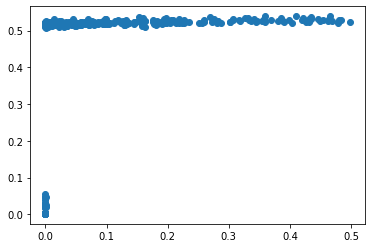

In [168]:
plt.scatter(df.d, df.ed_norm)

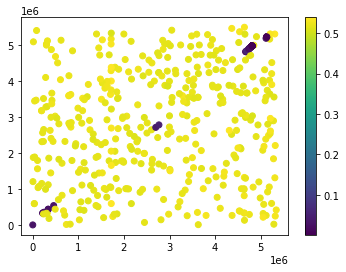

In [169]:
plt.scatter(df.i1, df.j1, c=df.ed_norm)
plt.colorbar()

In [189]:
index = 1
i, j, d = int(dists[index,0]),int(dists[index,1]), dists[index,2]
for C in range(0,100,5):
    i, j = i + C, j+C
    d = np.linalg.norm(sk1[:,i]- sk2[:,j])
    idx1,idx2 = all_seqs[s1]['sketch']['inds'][i], all_seqs[s2]['sketch']['inds'][j]
    seq1, seq2 = all_seqs[s1]['seq'][idx1-window:idx1],all_seqs[s2]['seq'][idx2-window:idx2]
    query, target = seq1,seq2
    result = edlib.align(query,target,task='path')
    nice = edlib.getNiceAlignment(result, query, target)
    first = nice['matched_aligned'].find('|'*10)
    query_aligned = nice['query_aligned'][:first]
    target_aligned = nice['target_aligned'][:first]
    d1, d2 = query_aligned.count('-'), target_aligned.count('-')
    L = window - max(d1,d2)
    result2 = edlib.align(target[d1:d1+L],query[d2:d2+L])
    ed, ed_norm = result2['editDistance'],result2['editDistance']/L
    print(f'{i}, {j}, {d:.5f}, {ed_norm:.3f}')


4814, 4979, 0.00300, 0.003
4819, 4984, 0.01001, 0.003
4829, 4994, 0.02654, 0.005
4844, 5009, 0.04937, 0.152
4864, 5029, 0.19552, 0.512
4889, 5054, 0.19397, 0.522
4919, 5084, 0.10261, 0.516
4954, 5119, 0.59615, 0.525
4994, 5159, 0.31066, 0.526
5039, 5204, 0.26405, 0.521
5089, 5254, 0.35869, 0.522
5144, 5309, 0.15728, 0.519
5204, 5369, 0.36323, 0.523
5269, 5434, 0.21922, 0.527
5339, 5504, 0.35497, 0.524


IndexError: index 5414 is out of bounds for axis 1 with size 5358

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

N = len(all_seqs)

for i in range(N):
    for j in range(i,N):
        sk1 = all_seqs[i]['sketch']['array']
        sk2 = all_seqs[j]['sketch']['array']
        sk1 = sk1.transpose() / np.sqrt(np.sum(sk1**2,axis=1))
        sk2 = sk2.transpose() / np.sqrt(np.sum(sk2**2,axis=1))
        prod = np.matmul(sk1.transpose(),sk2)
        angle = np.arccos(prod) / np.pi

        plt.matshow(angle)
        plt.colorbar()
        plt.title(f'seq {i} vs. seq {j}')
        plt.show()

In [ ]:
dists.shape

In [ ]:
x = np.arange(-1,1,.01)
plt.plot(x,np.arccos(x))